# <font style = "color:rgb(50,120,229)">Deep Learning based Face Recognition using OpenCV</font>

In this module, we will be discussing about a Face Recognition model provided in the OpenCV DNN module. It is developed at CMU, which goes by the name [OpenFace](http://cmusatyalab.github.io/openface/). 

It is based on the CVPR paper [FaceNet : A Unified Embedding for Face Recognition and Clustering](https://www.cv-foundation.org/openaccess/content_cvpr_2015/app/1A_089.pdf), but uses a relatively smaller dataset than the original implementation. It uses the Torch library for training the model.

The model is trained on 500K images using the datasets [FaceScrub](http://vintage.winklerbros.net/facescrub.html) and 
[CASIA-WebFace](https://arxiv.org/abs/1411.7923). It has a accuracy of 92.9% on the [LFW benchmark](http://vis-www.cs.umass.edu/lfw/results.html). This is quite an improvement considering the previous traditional methods of Eigen, Fisher or LBPH. They have also compared the accuracy of their method with these traditional methods as given in chart below. So, as the number of people increase, the traditional methods start to fail.

![](https://i.imgur.com/9KU9BJx.png)

We will not go into the theory of FaceNet in this chapter. However, the main concepts are similar to the dlib face recognition model, which we discuss in the next chapter. We will directly go over the code in the next section.

# <font style = "color:rgb(50,120,229)">Enrollment</font>

Unlike Eigenfaces and Fisherfaces, where in most modern face verification systems, training and enrollment are two different steps. Training is performed on millions of images. On the other hand, enrollment is performed using a small set of images. 

In case of OpenFace ( and also Dlib as discussed in the next chapter ), enrolling a person is simply passing a few images of the person through the network to obtain 128 dimensional feature descriptors corresponding to each image. In other words, we convert each image to a feature in a high-dimensional space. 

In this high dimensional space, features belonging to the same person will be close to each other and far away for different persons.

In [1]:
import os,sys
import dlib
import cv2
import numpy as np
import faceBlendCommon as fbc
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [2]:
import _pickle as cPickle

In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

## <font style="color:rgb(50,120,229)">Load the model for face landmarks and face recognition</font>

In [4]:
# Path to landmarks and face recognition model files
facerecModelPath = DATA_PATH + 'models/openface.nn4.small2.v1.t7'
recModel = cv2.dnn.readNetFromTorch(facerecModelPath)
recMean = [0,0,0]
recSize = (96, 96)#The size on which Model was trained
recScale = 1/255.0

# Initialize face detector
faceDetector = dlib.get_frontal_face_detector()
PREDICTOR_PATH = DATA_PATH + "models/shape_predictor_5_face_landmarks.dat"
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

## <font style="color:rgb(50,120,229)">Load the data for enrollment </font>

Persons’ images we are going to enroll are structured in following way:

`DATA_PATH/images/faces` folder will have subfolders

Each subfolder has images of one person

We will store this mapping of images and their corresponding labels to use it later in testing

In [5]:
# Now let's prepare our training data
# data is organized assuming following structure
# faces folder has subfolders.
# each subfolder has images of a person
faceDatasetFolder = DATA_PATH + 'images/faces'

# read subfolders in folder "faces"
subfolders = []
for x in os.listdir(faceDatasetFolder):
  xpath = os.path.join(faceDatasetFolder, x)
  if os.path.isdir(xpath):
    subfolders.append(xpath)

# nameLabelMap is dict with keys as person's name
# and values as integer label assigned to this person
# labels contain integer labels 
# for corresponding image in imagePaths
nameLabelMap = {}
labels = []
imagePaths = []
for i, subfolder in enumerate(subfolders):
  for x in os.listdir(subfolder):
    xpath = os.path.join(subfolder, x)
    if x.endswith('jpg'):
      imagePaths.append(xpath)
      labels.append(i)
      nameLabelMap[xpath] = subfolder.split('/')[-1]

## <font style="color:rgb(50,120,229)">Process each image in the dataset and compute descriptors</font>

Process enrollment images one by and one. 

Convert image from BGR to RGB, because Dlib uses RGB as default format.

Detect the faces in each image.

Compute face descriptor using the DNN model. This is a 128 dimensional vector which represents a face.

For each face descriptor we will also save the corresponding label.
Order of face descriptor for each face in faceDescriptors NumPy array’s rows is same as the order of labels in variable index.

In [6]:
# Process images one by one
# We will store face descriptors in an ndarray (faceDescriptors)
# and their corresponding labels in dictionary (index)
index = {}
i = 0
faceDescriptors = None
for imagePath in imagePaths:
  print("processing: {}".format(imagePath))
  # read image and convert it to RGB
  img = cv2.imread(imagePath)

  # detect faces in image
  faces = faceDetector(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

  print("{} Face(s) found".format(len(faces)))

  # Now process each face we found
  for k, face in enumerate(faces):

    alignedFace = fbc.alignFace(img, face, landmarkDetector, recSize)

    # Compute face descriptor using OpenFace network.
    # It is a 128D vector that describes the face.
    blob = cv2.dnn.blobFromImage(alignedFace, recScale, recSize, recMean, False, False)
    recModel.setInput(blob)
    faceDescriptor = recModel.forward()

    # Stack face descriptors (1x128) for each face in images, as rows
    if faceDescriptors is None:
      faceDescriptors = faceDescriptor
    else:
      faceDescriptors = np.concatenate((faceDescriptors, faceDescriptor), axis=0)

    # save the label for this face in index. We will use it later to identify
    # person name corresponding to face descriptors stored in NumPy Array
    index[i] = nameLabelMap[imagePath]
    i += 1

processing: ../data/images/faces\satya\face2_000326.jpg
1 Face(s) found
processing: ../data/images/faces\satya\face2_000757.jpg
1 Face(s) found
processing: ../data/images/faces\satya\intro_000007.jpg
1 Face(s) found
processing: ../data/images/faces\satya\intro_000103.jpg
1 Face(s) found
processing: ../data/images/faces\satya\intro_000151.jpg
1 Face(s) found
processing: ../data/images/faces\satya\making_000319.jpg
1 Face(s) found
processing: ../data/images/faces\satya\making_003991.jpg
1 Face(s) found
processing: ../data/images/faces\satya\satya_making_004146.jpg
1 Face(s) found
processing: ../data/images/faces\satya\satya_making_004208.jpg
1 Face(s) found
processing: ../data/images/faces\satya\satya_making_004377.jpg
1 Face(s) found
processing: ../data/images/faces\vikas\vikas_01.jpg
1 Face(s) found
processing: ../data/images/faces\vikas\vikas_03.jpg
1 Face(s) found
processing: ../data/images/faces\vikas\vikas_04.jpg
1 Face(s) found
processing: ../data/images/faces\vikas\vikas_07.jpg
1

## <font style="color:rgb(50,120,229)">Save the updated model</font>

Now save descriptors and the descriptor-label mapping to disk.

In [8]:
# Write descriors and index to disk
np.save('descriptors_openface.npy', faceDescriptors)
# index has image paths in same order
#  as descriptors in faceDescriptors
with open('index_openface.pkl', 'wb') as f:
  cPickle.dump(index, f)

# <font style = "color:rgb(50,120,229)">Testing</font>

Given a new image of a person, we can verify if it is the same person by checking the distance between the enrolled faces and the new face in the 128 dimensional space. 

Initialize Dlib’s Face Detector, Facial Landmark Detector and Face Recognition neural network objects.

In [9]:
facerecModelPath = DATA_PATH + 'models/openface.nn4.small2.v1.t7'
recModel = cv2.dnn.readNetFromTorch(facerecModelPath)
recMean = [0,0,0]
recSize = (96, 96)
recScale = 1/255.0
recThreshold = 0.8


# Initialize face detector
faceDetector = dlib.get_frontal_face_detector()
PREDICTOR_PATH = DATA_PATH + "models/shape_predictor_5_face_landmarks.dat"
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

# load descriptors and index file generated during enrollment
index = np.load('index_openface.pkl',allow_pickle = True)
faceDescriptorsEnrolled = np.load('descriptors_openface.npy')

## <font style="color:rgb(50,120,229)">Load the test image</font>

Read the query image and convert it from BGR to RGB. Because Dlib uses RGB as default format.

In [10]:
imagePath = DATA_PATH + 'images/faces/satya_demo.jpg'
im = cv2.imread(imagePath, cv2.IMREAD_COLOR)

# exit if unable to read frame from feed
if im is None:
  print ('cannot read image')

## <font style="color:rgb(50,120,229)">Detect faces in query image.</font>

In [11]:
faces = faceDetector(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

print("{} Face(s) found".format(len(faces)))

1 Face(s) found


## <font style="color:rgb(50,120,229)">Inference </font>
For each face, first align it and then compute face descriptor.

Finally, we find the closest match using L2 distance 

In [12]:
for face in faces:

  # find coordinates of face rectangle
  x1 = face.left()
  y1 = face.top()
  x2 = face.right()
  y2 = face.bottom()

  alignedFace = fbc.alignFace(im, face, 
                              landmarkDetector, 
                              recSize)

  # Compute face descriptor using neural network 
  # defined in Dlib.
  # It is a 128D vector 
  # that describes the face in img identified 
  # by shape.
  blob = cv2.dnn.blobFromImage(alignedFace, recScale, 
                               recSize, recMean, 
                               False, False)
  recModel.setInput(blob)
  faceDescriptorQuery = recModel.forward()

  # Calculate Euclidean distances between face descriptor 
  # calculated on face dectected
  # in current frame with all the face descriptors 
  # we calculated while enrolling faces
  distances = np.linalg.norm(faceDescriptorsEnrolled - 
              faceDescriptorQuery, axis=1)
  # Calculate minimum distance and index of this face
  argmin = np.argmin(distances)  # index
  minDistance = distances[argmin]  # minimum distance

  # If minimum distance if less than threshold
  # find the name of person from index
  # else the person in query image is unknown
  if minDistance <= recThreshold:
    label = index[argmin]
  else:
    label = 'unknown'

  # Draw a rectangle for detected face
  cv2.rectangle(im, (x1, y1), (x2, y2), (0, 0, 255))

  # Draw circle for face recognition
  center = (int((x1 + x2)/2.0), int((y1 + y2)/2.0))
  radius = int((y2-y1)/2.0)
  color = (0, 255, 0)
  cv2.circle(im, center, 
             radius, color, 
             thickness=1, lineType=8, 
             shift=0)

  # Write test on image specifying identified person 
  # and minimum distance
  # bottom left corner of text string
  org = (int(x1), int(y1))  
  font_face = cv2.FONT_HERSHEY_SIMPLEX
  font_scale = 0.8
  text_color = (255, 0, 0)
  printLabel = '{} {:0.4f}'.format(label, minDistance)
  cv2.putText(im, printLabel, org, font_face, font_scale, 
              text_color, thickness=2)

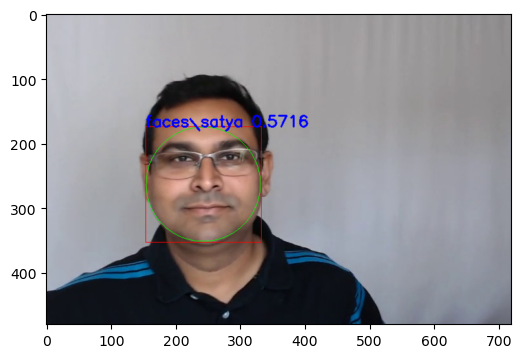

In [13]:
# Show result
plt.imshow(im[:,:,::-1])
plt.show()

# <font style = "color:rgb(50,120,229)">References and Further Reading</font>

1. [[OpenFace Technical Report]](http://reports-archive.adm.cs.cmu.edu/anon/2016/CMU-CS-16-118.pdf)
2. [[OpenCV DNN sample for OpenFace]](https://github.com/opencv/opencv/blob/master/samples/dnn/js_face_recognition.html)